In [12]:
import pharmada.data.data as data

regkey = '09663'

model = data.Data(regkey)
model

Pharmada model data for Kreisfreie Stadt Würzburg (09663).
Pharmacies in area: 41.
Customers in area:  5280.

In [2]:
import geopandas as gpd
from scipy.spatial import KDTree
import numpy as np
from shapely.geometry import Point, MultiPoint

# Assuming df1 and df2 are your dataframes and they have a 'geometry' column with Point geometries

# Reproject dataframes to a metric CRS (if they aren't in one already) for correct distance calculation
crs = model.AreaGeometry.geometry.estimate_utm_crs()
customers = model.Customers.customers.to_crs(crs)
pharmacies = model.Pharmacies.pharmacies.to_crs(crs)

def closest(point, points):
    """Return closest point from a list of points."""
    return points[np.argmin([point.distance(p) for p in points])]

# Create KDTree object
tree = KDTree(pharmacies.geometry.apply(lambda geom: (geom.x, geom.y)).tolist())

# Find indices of the nearest pharmacy for each customer
distances, indices = tree.query(customers.geometry.apply(lambda geom: (geom.x, geom.y)).tolist(), k=1)

# Add nearest pharmacy id to customer df
customers['nearest_pharmacy'] = indices.tolist()


In [4]:
results = []

# Assign customers to pharmacies and write results to GeoDataFrame
for pharmacy_id in pharmacies.index:
    customers_at_pharmacy = customers.loc[customers["nearest_pharmacy"] == pharmacy_id, "geometry"]
    if not customers_at_pharmacy.empty:
        results.append({"pharmacy_id": pharmacy_id, "customers": MultiPoint(customers_at_pharmacy.tolist())})

results = gpd.GeoDataFrame(results, geometry="customers")

# Convert 'pharmacy_id' to int and 'customers' to GeoSeries
results["pharmacy_id"] = results["pharmacy_id"].astype(int)
results["customers"] = gpd.GeoSeries(results["customers"])

# Set the CRS for the GeoDataFrame to match the input DataFrames
results.set_crs(crs, inplace=True)  # adjust this to match your CRS

,pharmacy_id,customers
0,0,"MULTIPOINT (569360.107 5507657.209, 569409.899..."
1,1,"MULTIPOINT (568867.217 5510510.087, 568873.827..."
2,2,"MULTIPOINT (568151.016 5511932.596, 568245.925..."
3,3,"MULTIPOINT (567073.177 5512136.108, 567179.891..."
4,4,"MULTIPOINT (564123.359 5513384.540, 564531.411..."
5,5,"MULTIPOINT (563529.576 5517192.966, 564639.089..."
6,6,"MULTIPOINT (567302.127 5514881.067, 567311.902..."
7,7,"MULTIPOINT (565682.113 5513598.904, 565802.353..."
8,8,"MULTIPOINT (565762.791 5515123.683, 565869.833..."
9,9,"MULTIPOINT (566168.080 5515249.541, 566309.250..."


In [7]:
num_cus = results.apply(lambda x: len(x['customers'].geoms), axis=1)
pharmacies['num_cus'] = num_cus

<Axes: >

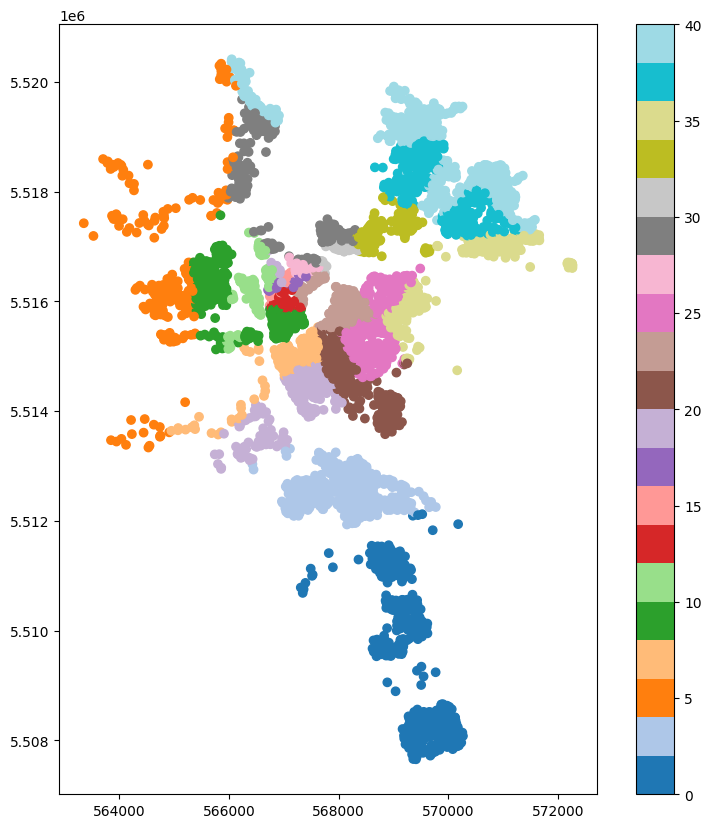

In [8]:
customers.groupby('nearest_pharmacy')
customers.plot(cmap='tab20', column='nearest_pharmacy', legend=True, figsize=(10, 10))

In [9]:
test = customers.groupby('nearest_pharmacy').aggregate({'geometry': lambda x: MultiPoint(x.tolist())})

<Axes: >

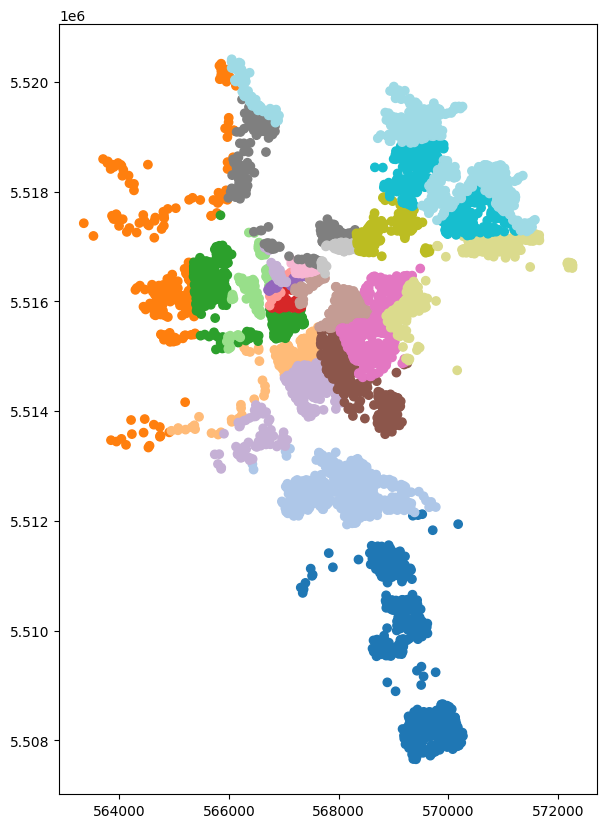

In [10]:
test.set_geometry('geometry', inplace=True)
test.plot(cmap='tab20', figsize=(10, 10))

In [11]:
customers

,geometry,regkey,name,nearest_pharmacy
0,POINT (569360.107 5507657.209),09663,Kreisfreie Stadt Würzburg,0
1,POINT (569409.899 5507652.475),09663,Kreisfreie Stadt Würzburg,0
2,POINT (569338.594 5507741.841),09663,Kreisfreie Stadt Würzburg,0
3,POINT (569389.968 5507691.720),09663,Kreisfreie Stadt Würzburg,0
4,POINT (569423.646 5507699.735),09663,Kreisfreie Stadt Würzburg,0
...,...,...,...,...
5300,POINT (569144.076 5519092.731),09663,Kreisfreie Stadt Würzburg,38
5301,POINT (569330.188 5519077.696),09663,Kreisfreie Stadt Würzburg,38
5302,POINT (569368.123 5519259.900),09663,Kreisfreie Stadt Würzburg,38
5303,POINT (566475.652 5519431.604),09663,Kreisfreie Stadt Würzburg,28
